## Import Libraries

In [72]:
# Import necessary libraries

import pandas as pd
import numpy as np
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score, roc_curve, roc_auc_score, auc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [2]:
df = pd.read_csv('spam.csv')
df.head(10)

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...

In [3]:
df.shape

(5572, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.describe(include="object").T

count unique                     top  freq
Category  5572      2                     ham  4825
Message   5572   5157  Sorry, I'll call later    30

In [6]:
#find missing values
df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})

Total No. of Missing Values
Category                            0
Message                             0

Text(0.5, 1.0, 'Distribution of missing values')

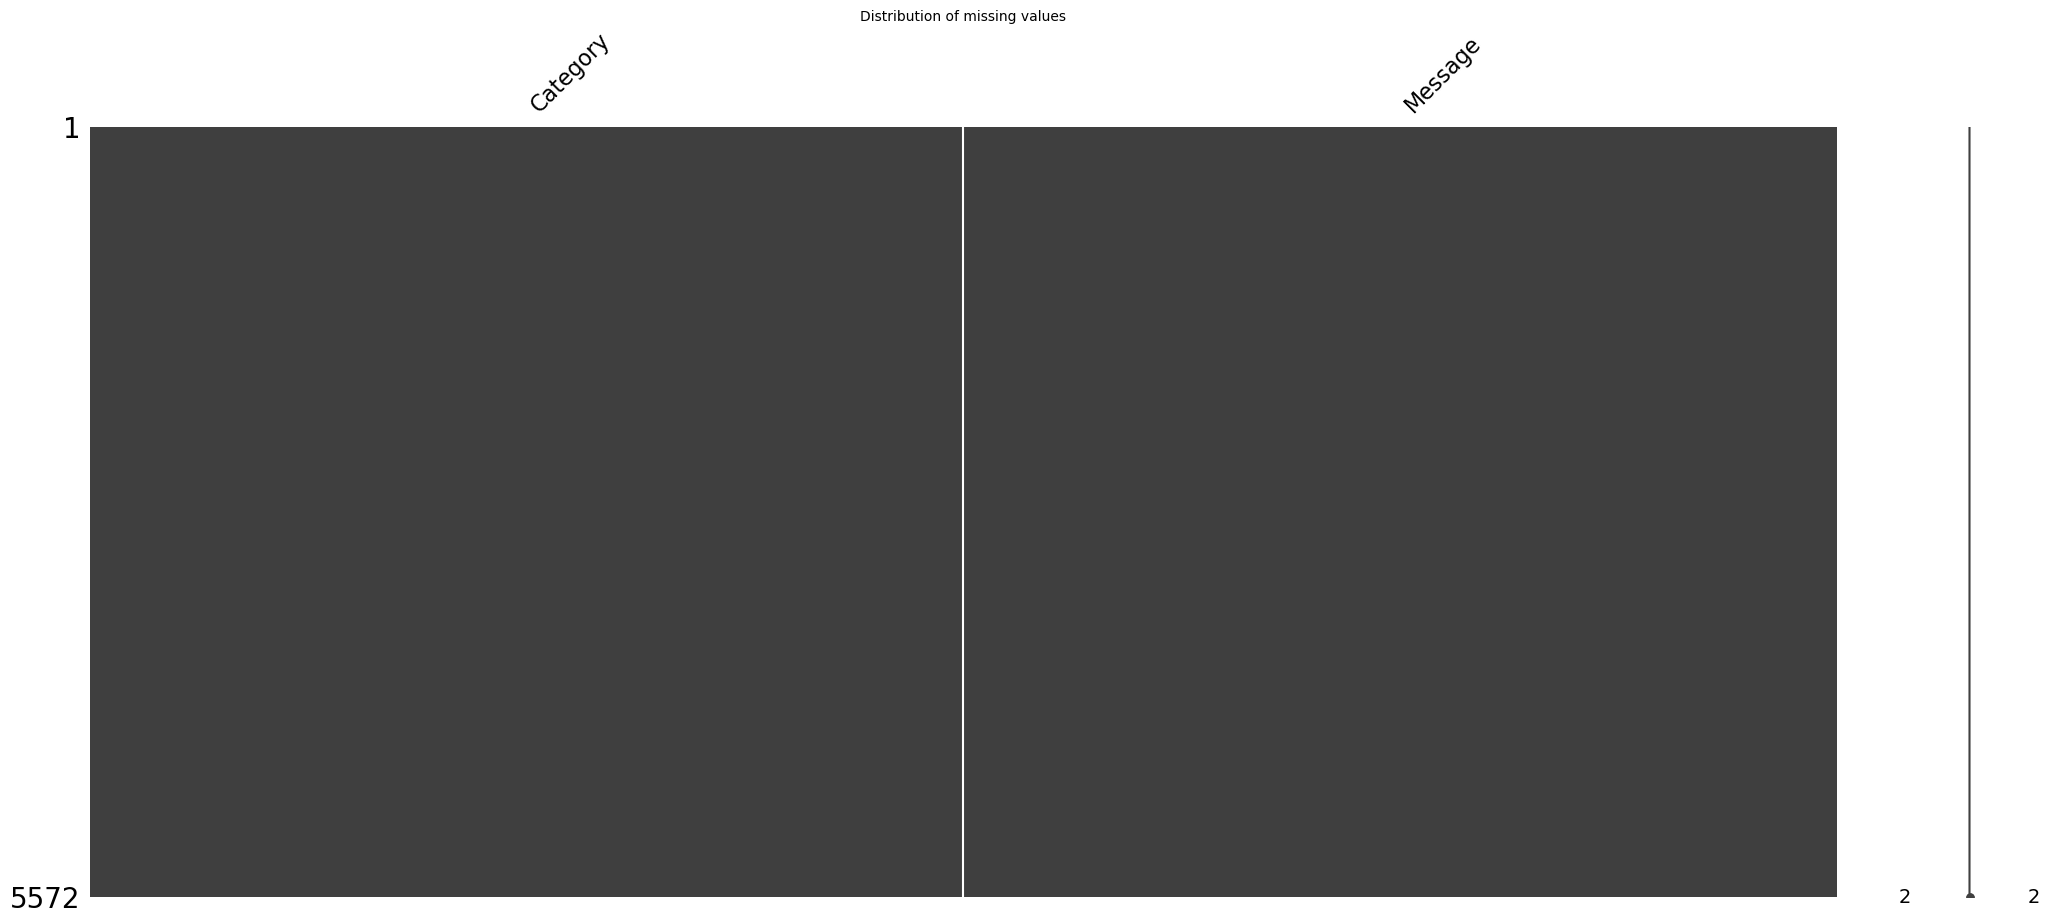

In [7]:
# Plot Null Count Analysis
msno.matrix(df).set_title('Distribution of missing values',fontsize = 10)

Category
ham     4825
spam     747
Name: count, dtype: int64


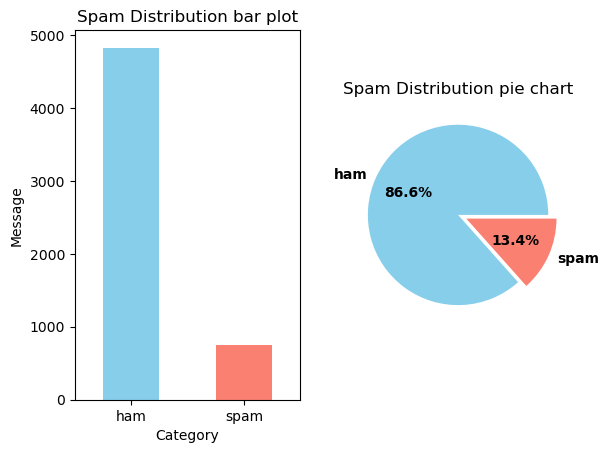

In [8]:
#visualization of dataset distribution
counts = df["Category"].value_counts()
print(counts)

plt.subplot(1, 2, 1)
counts.plot(kind="bar", color=['skyblue', 'salmon'])
plt.xlabel('Category')
plt.ylabel('Message')
plt.title('Spam Distribution bar plot')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(counts.values, labels=counts.index, autopct="%1.1f%%", colors=['skyblue', 'salmon'],
        textprops={"fontweight":"black"}, explode=[0, 0.1])
plt.title("Spam Distribution pie chart")
plt.savefig('Spam Distribution pie chart.png')
plt.show()

In [9]:
#checking for class imbalance
print(df['Category'].value_counts())

Category
ham     4825
spam     747
Name: count, dtype: int64


## Data Preprocessing

#### adding an extra column 'length' of message in the next section.

In [10]:
#Cleaning and preprocessing the text data by removing stopwords, punctuation, and converting text to lowercase.
stop_words = set(stopwords.words('english'))

def preprocess_text(Message):
    tokens = word_tokenize(Message.lower())
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(filtered_tokens)

df['Clean_message'] = df['Message'].apply(preprocess_text)
df.head()

Category                                            Message  \
0      ham  Go until jurong point, crazy.. Available only ...   
1      ham                      Ok lar... Joking wif u oni...   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3      ham  U dun say so early hor... U c already then say...   
4      ham  Nah I don't think he goes to usf, he lives aro...   

                                       Clean_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4             nah think goes usf lives around though

In [11]:
categories = pd.get_dummies(df['Category'])
spam_or_not = pd.concat([df, categories], axis=1)
spam_or_not.drop('Category',axis=1,inplace=True)

df['length'] = df['Message'].apply(len)

ham = df.loc[np.where(spam_or_not['ham'] == 1)].reset_index()
spam = df.loc[np.where(spam_or_not['ham'] == 0)].reset_index()

ham.drop('index',axis=1,inplace=True)
spam.drop('index',axis=1,inplace=True)

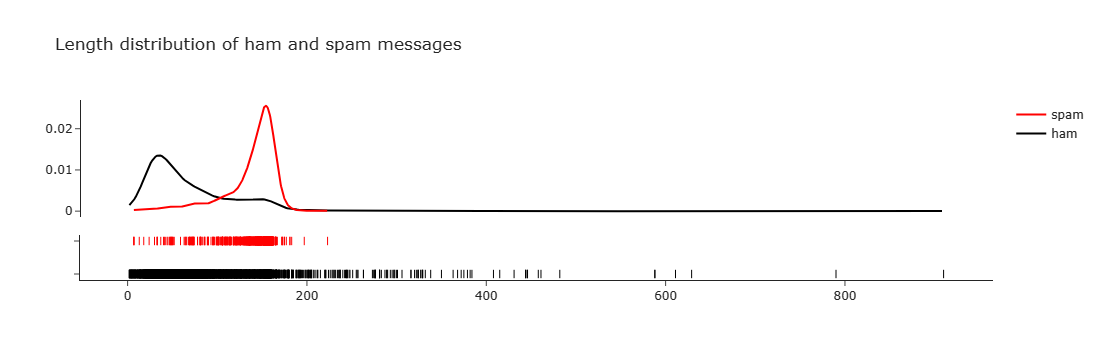

In [12]:
#plot length distribtion of ham and spam emails
hist_data = [ham['length'],spam['length']]

group_labels = ['ham','spam']

colors = ['black', 'red']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Length distribution of ham and spam messages',
                 template = 'simple_white')
fig.show()

In [13]:
# function to get all of strings from dataframe column, and used lower function here.
def get_all_str(df):
    sentence = ''
    for i in range(len(df)):
        sentence += df['Message'][i]
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# function to get words from text(string). used RegexpTokenizer
def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
#     result = result.lower()                                              
#     result = nltk.word_tokenize(text)
    return result

# function to add stopwords to nltp stopword list.
def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

# function to remove stopwords from list.
def remove_stopword(stopwords, lst):
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
    return cleanwordlist

# function to get dataframe from cleanwordlist.
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['length']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['length'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to lemmatize words
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

In [14]:
string_ham = get_all_str(ham)
words_ham = get_word(string_ham)
removed_ham = remove_stopword('1',words_ham)
# show 10 words for example
print(removed_ham[:10])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la']


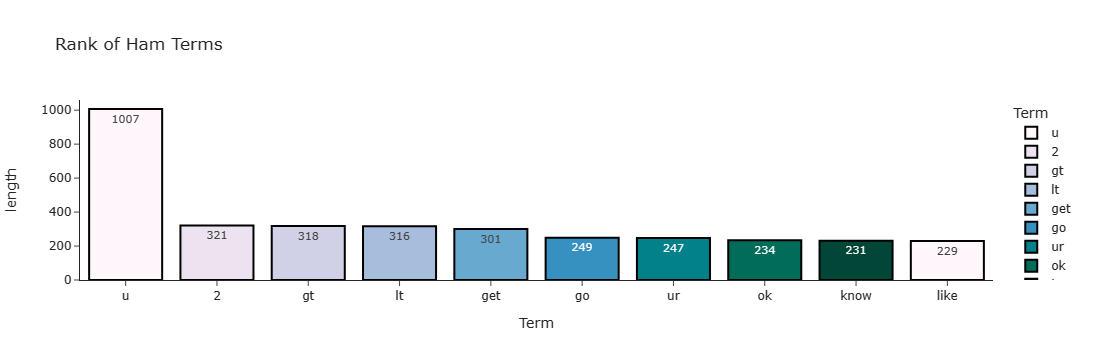

In [15]:
# Data visualization - Most Common Words in ham Emails
freq_df_ham = Freq_df(removed_ham)
top_10_ham = freq_df_ham[:10]

fig = px.bar(top_10_ham, x = 'Term', y = 'length',text = 'length', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, 
             title = 'Rank of Ham Terms',
             template = "simple_white"
              )

for idx in range(len(top_10_ham)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

In [16]:
# function to plot word cloud of words
def Word_Cloud(df, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=100,
               colormap= colormap,
               max_font_size=140,
               min_font_size = 2,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(df)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

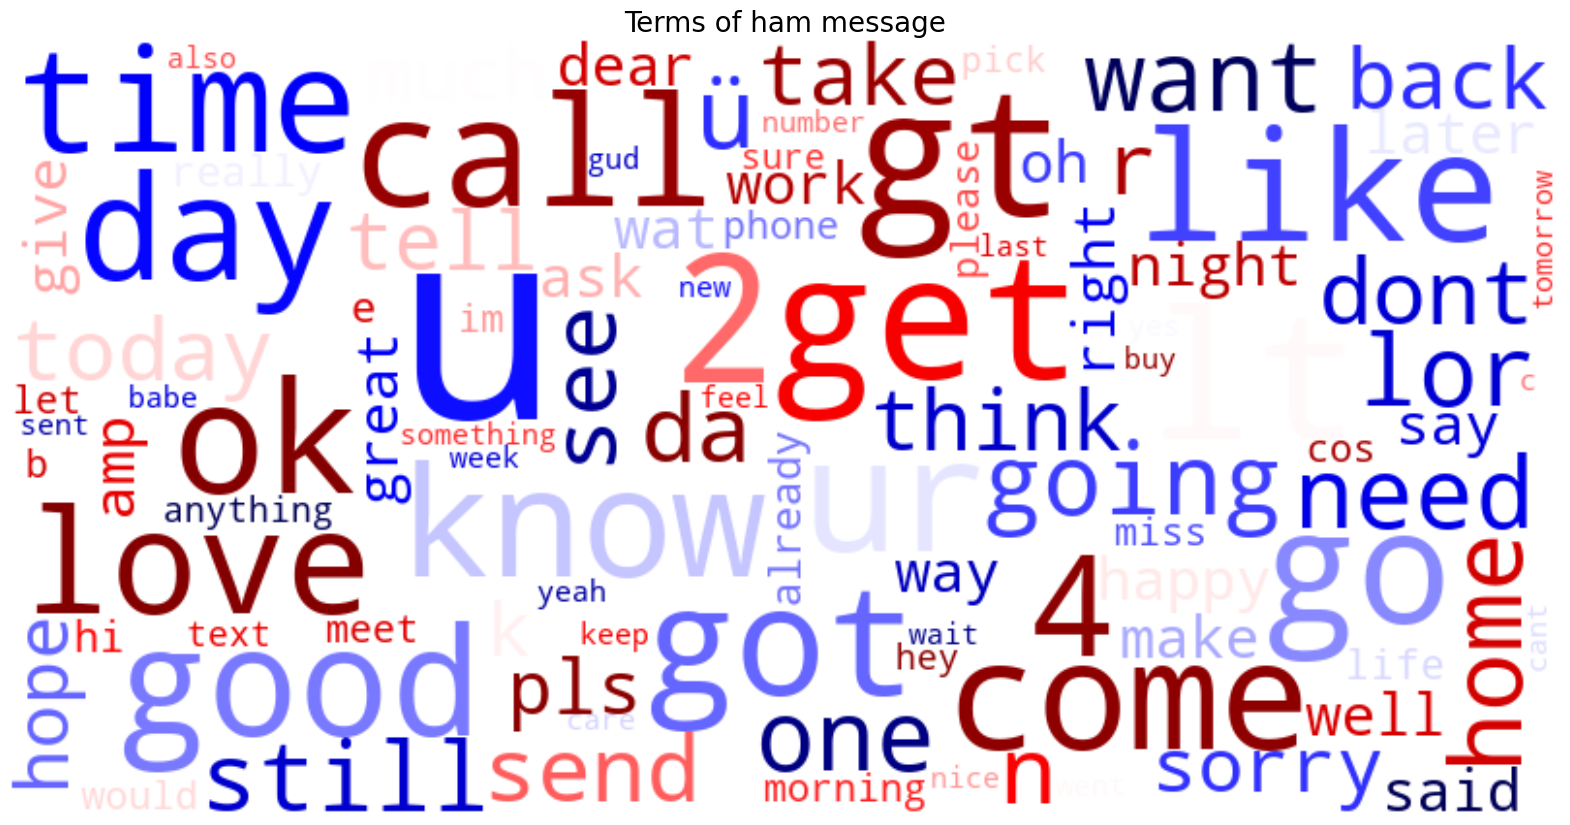

In [17]:
# wordcould visualization of Most Common Words in ham Emails
data_ham = dict(zip(freq_df_ham['Term'].tolist(), freq_df_ham['length'].tolist()))
data_ham = freq_df_ham.set_index('Term').to_dict()['length']

ham_wordcloud = Word_Cloud(data_ham ,'white', 'seismic', 'Terms of ham message')

In [18]:
string_spam = get_all_str(spam)
words_spam = get_word(string_spam)
removed_spam = remove_stopword('1',words_spam)
# show 10 words for example
print(removed_spam[:10])

['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts']


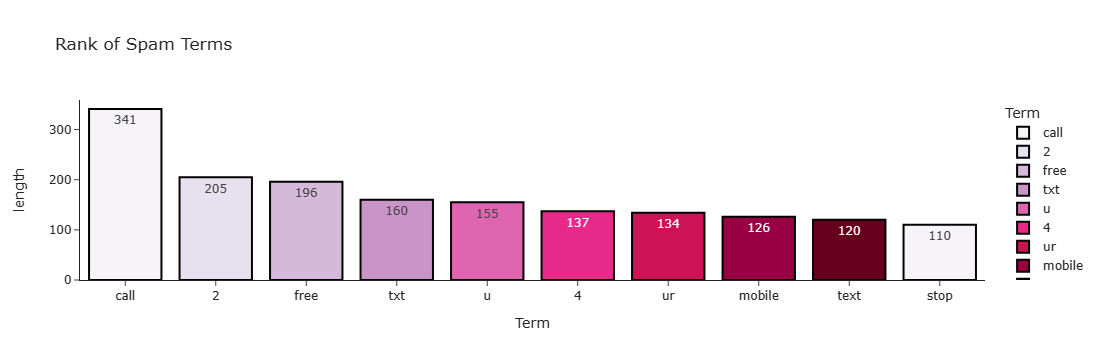

In [19]:
# Data visualization - Most Common Words in spam Emails
freq_df_spam = Freq_df(removed_spam)
top_10_spam = freq_df_spam[:10]

fig = px.bar(top_10_spam, x = 'Term', y = 'length',text = 'length',
             color_discrete_sequence=px.colors.sequential.PuRd, 
             title = 'Rank of Spam Terms', 
             template = "simple_white",
             color='Term')

for idx in range(len(top_10_spam)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.show()

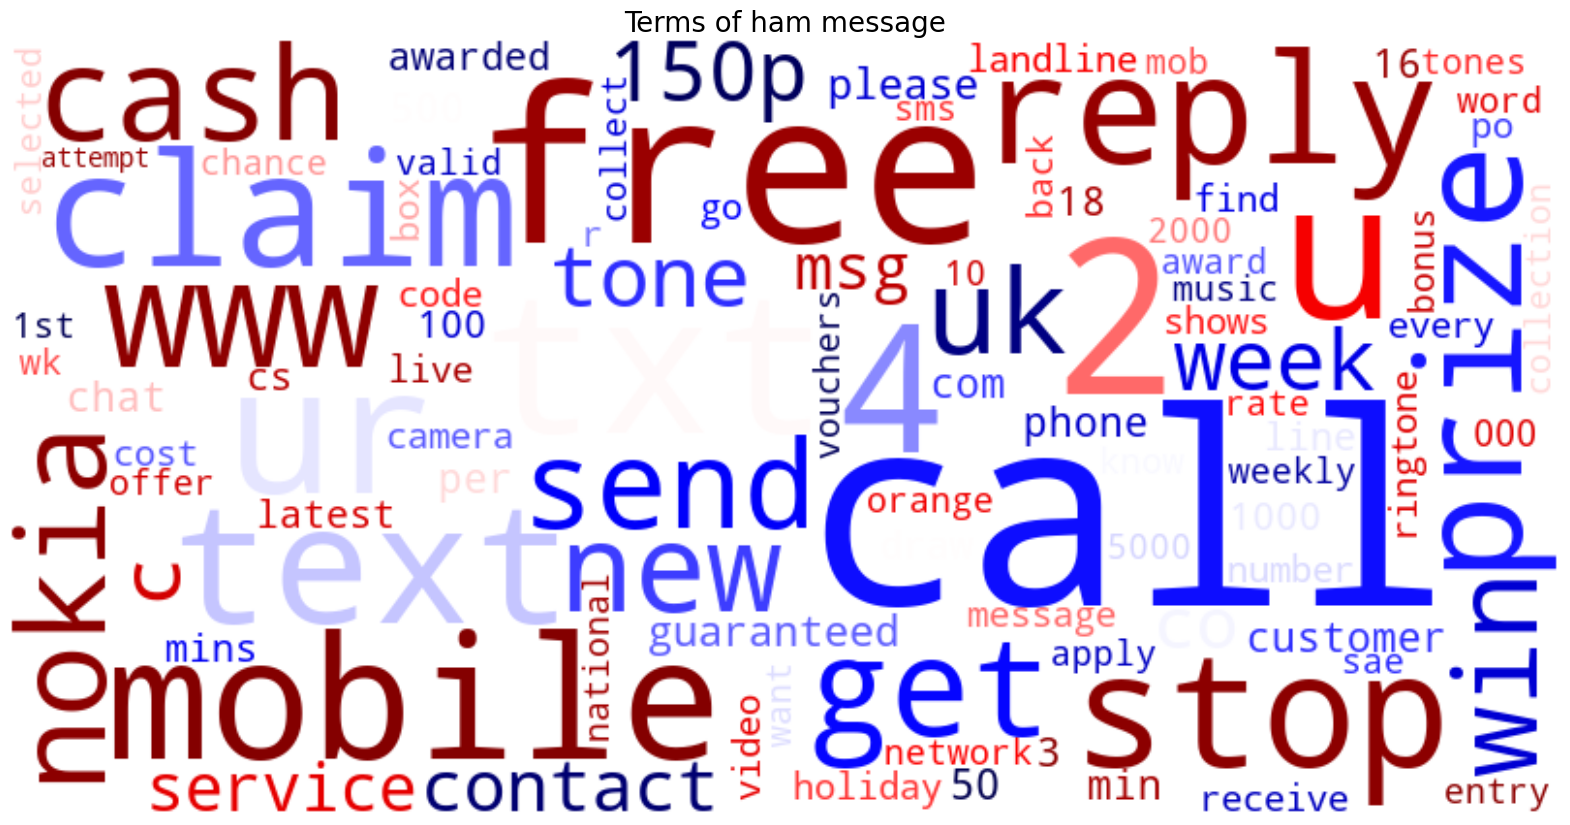

In [20]:
# wordcould visualization of Most Common Words in spam Emails
data_spam = dict(zip(freq_df_spam['Term'].tolist(), freq_df_spam['length'].tolist()))
data_spam = freq_df_spam.set_index('Term').to_dict()['length']

spam_wordcloud = Word_Cloud(data_spam, 'white','seismic', 'Terms of ham message')

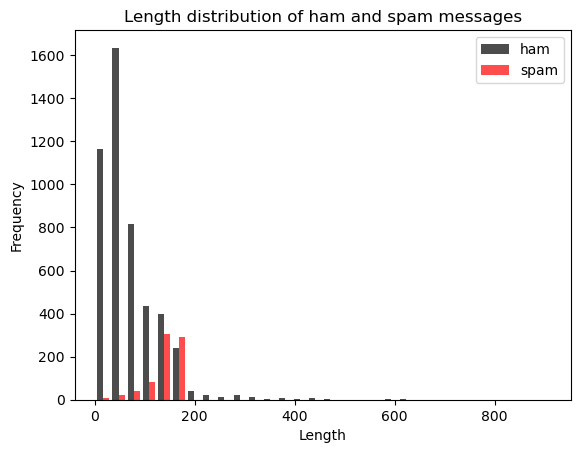

In [21]:
# Data
hist_data_plt = [ham['length'], spam['length']]
group_labels = ['ham', 'spam']
colors = ['black', 'red']

# Create histogram
plt.hist(hist_data, bins=30, label=group_labels, color=colors, alpha=0.7)

# Add labels and title
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Length distribution of ham and spam messages')

# Add legend
plt.legend()

# Show plot
plt.show()

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

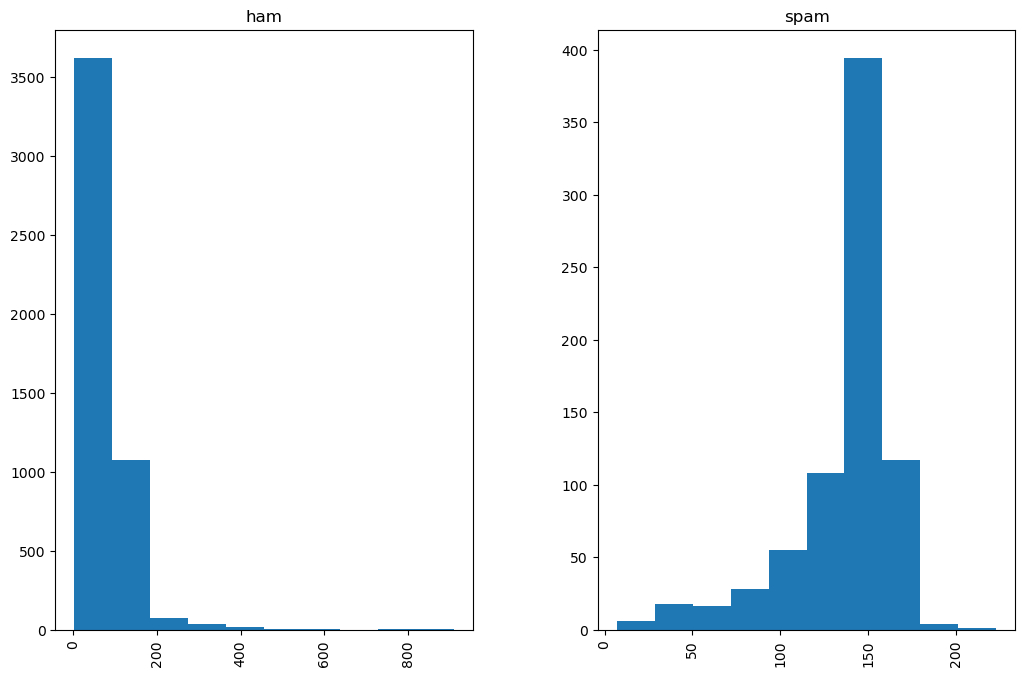

In [22]:
# distribution of spam and ham by length of text
df.hist(column='length',by='Category',figsize=(12,8))

## Data Preprocessing 

In [23]:
#Label encoding for category variable
df.loc[df['Category'] == 'spam', 'Category'] = 0
df.loc[df['Category'] == 'ham', 'Category'] = 1

In [24]:
df.head(10)

Category                                            Message  \
0        1  Go until jurong point, crazy.. Available only ...   
1        1                      Ok lar... Joking wif u oni...   
2        0  Free entry in 2 a wkly comp to win FA Cup fina...   
3        1  U dun say so early hor... U c already then say...   
4        1  Nah I don't think he goes to usf, he lives aro...   
5        0  FreeMsg Hey there darling it's been 3 week's n...   
6        1  Even my brother is not like to speak with me. ...   
7        1  As per your request 'Melle Melle (Oru Minnamin...   
8        0  WINNER!! As a valued network customer you have...   
9        0  Had your mobile 11 months or more? U R entitle...   

                                       Clean_message  length  
0  go jurong point crazy available bugis n great ...     111  
1                            ok lar joking wif u oni      29  
2  free entry 2 wkly comp win fa cup final tkts 2...     155  
3                u dun say early hor u c already say      49  
4             nah think goes usf lives around though      61  
5  freemsg hey darling 3 week word back like fun ...     147  
6     even brother like speak treat like aids patent      77  
7  per request melle oru minnaminunginte nurungu ...     160  
8  winner valued network customer selected receiv...     157  
9  mobile 11 months u r entitled update latest co...     154

In [25]:
# Separate the feature (message) and target (category) data
x = df["Clean_message"]
y = df["Category"]

In [26]:
x

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4                  nah think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u pound prize 2 claim...
5568                          ü b going esplanade fr home
5569                                pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: Clean_message, Length: 5572, dtype: object

In [27]:
y

0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: Category, Length: 5572, dtype: object

## Feature Extraction

In [28]:
# Create TF-IDF Vectorizer
feature_extraction = TfidfVectorizer()

In [29]:
# Initialize TF-IDF Vectorizer
feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)
feature_extraction

TfidfVectorizer(stop_words='english')

In [30]:
# Feature extraction for training and testing data
#x = feature_extraction.fit_transform(x)
x = feature_extraction.fit_transform(x)
y = df['Category'].values

## Splitting the data into train and test set

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [32]:
x_train

<4457x7922 sparse matrix of type '<class 'numpy.float64'>'
	with 31936 stored elements in Compressed Sparse Row format>

In [33]:
x_test

<1115x7922 sparse matrix of type '<class 'numpy.float64'>'
	with 7995 stored elements in Compressed Sparse Row format>

In [34]:
y_train

array([0, 1, 1, ..., 1, 1, 1], dtype=object)

In [35]:
y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=object)

In [36]:
# Print the shape of train and test set
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457, 7922)
(1115, 7922)
(4457,)
(1115,)


In [37]:
# Convert Y_train and Y_test to integer type
y_train = y_train.astype("int")
y_test = y_test.astype("int")

##

## Model Selection and Train

## Naïve Bayes Model

In [38]:
#Import library for NB model
from sklearn.naive_bayes import MultinomialNB

In [39]:
#Build a Naïve Bayes model
nb_classifier = MultinomialNB()

In [40]:
#Intialize the NB model
nb_classifier.fit(x_train, y_train)

MultinomialNB()

In [41]:
#Make predictions on the test data
y_pred_nb = nb_classifier.predict(x_test)

In [42]:
# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naïve Bayes Accuracy:", accuracy_nb)
print("Naïve Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Accuracy: 0.9713004484304932
Naïve Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       149
           1       0.97      1.00      0.98       966

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



[[117  32]
 [  0 966]]


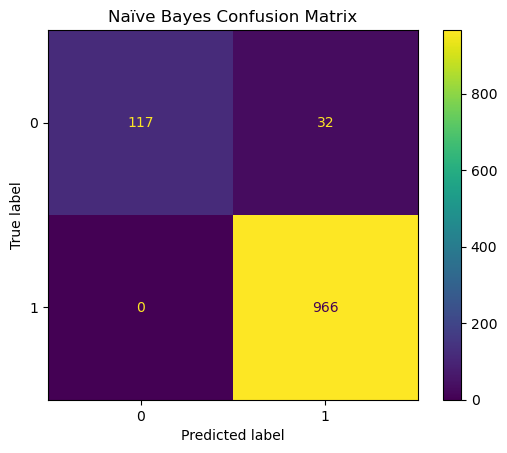

In [43]:
#Plot the confusion matrix for the nb model
cm_nb = confusion_matrix(y_test, y_pred_nb)
print(cm_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels = nb_classifier.classes_)
disp_nb.plot()
plt.title('Naïve Bayes Confusion Matrix')
plt.savefig('nb spam confusion matrix.png')
plt.show()

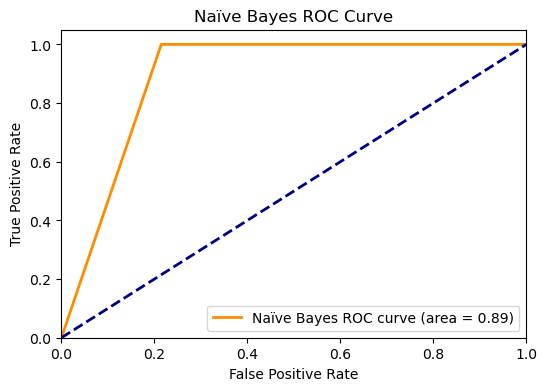

In [44]:
#Plot the Receiver Operating Characteristic (ROC) Curve

y_prob_nb = nb_classifier.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Naïve Bayes ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naïve Bayes ROC Curve')
plt.legend(loc='lower right')
plt.savefig('NB spam ROC Curve.png')
plt.show()

##

## K-Nearest Neighbour Model

In [45]:
#Import library for KNN model
from sklearn.neighbors import KNeighborsClassifier

In [46]:
# Define hyperparameters distribution
param_dist = {
    'n_neighbors': randint(1, 20),  # Random integer between 1 and 20
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm for computing nearest neighbors
}

# Define model
knn_classifier = KNeighborsClassifier()

# Randomized search
random_search = RandomizedSearchCV(estimator=knn_classifier, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search.fit(x_train, y_train)

# Get best hyperparameters
best_params_knn = random_search.best_params_
print("Best hyperparameters for KNN:", best_params_knn)

Best hyperparameters for KNN: {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}


In [47]:
#Initialize the KNN model
knn_classifier = KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto', weights = 'distance')

In [48]:
#Fit the model with the training set
knn_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [49]:
#Make predictions on the test data
y_pred_knn = knn_classifier.predict(x_test)

In [50]:
# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("K-Nearest Neighbour Accuracy:", accuracy_knn)
print("K-Nearest Neighbour Classification Report:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbour Accuracy: 0.9488789237668162
K-Nearest Neighbour Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.63      0.77       149
           1       0.95      1.00      0.97       966

    accuracy                           0.95      1115
   macro avg       0.96      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115



[[ 94  55]
 [  2 964]]


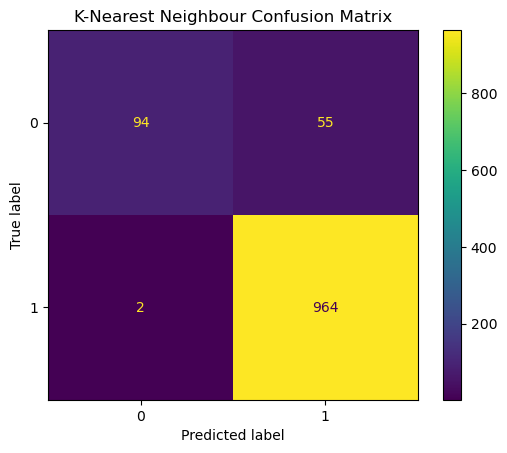

In [51]:
#Plot the confusion matrix for the nb model
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels = knn_classifier.classes_)
disp_knn.plot()
plt.title('K-Nearest Neighbour Confusion Matrix')
plt.savefig('knn spam confusion matrix.png')
plt.show()

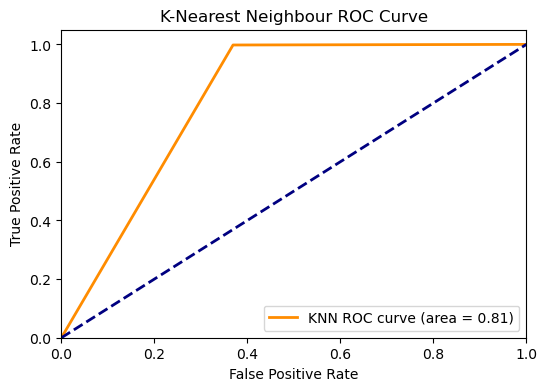

In [52]:
#Plot the Receiver Operating Characteristic (ROC) Curve

y_prob_knn = knn_classifier.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='KNN ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbour ROC Curve')
plt.legend(loc='lower right')
plt.savefig('KNN spam ROC Curve.png')
plt.show()

## 

## Support Vector Machine Model

In [53]:
#Building the support vector machine model
from sklearn.svm import SVC

In [54]:
# Define the parameter distribution
param_dist = {
    'C': randint(1, 20),  # Randomly sample C from a uniform distribution between 1 and 20
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(2, 6), # Randomly sample degree from a uniform distribution between 2 and 5
    'class_weight': ['balanced', 'None'] 
}

# Create SVM classifier
svm_classifier = SVC()

# Perform randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=svm_classifier, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1)

# Fit the randomized search to the data
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'C': 5, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}


In [55]:
#Initialize svm classifier
svm_classifier = SVC(kernel = 'linear', C = 2, class_weight = 'balanced', degree = 2, gamma = 'scale', probability = True)

In [56]:
#Train the model
svm_classifier.fit(x_train, y_train)

SVC(C=2, class_weight='balanced', degree=2, kernel='linear', probability=True)

In [57]:
#predict on the test set
y_pred_svm = svm_classifier.predict(x_test)

In [58]:
#Display the SVM accuracy report
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Accuracy: 0.9847533632286996
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       149
           1       0.98      1.00      0.99       966

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115



[[132  17]
 [  0 966]]


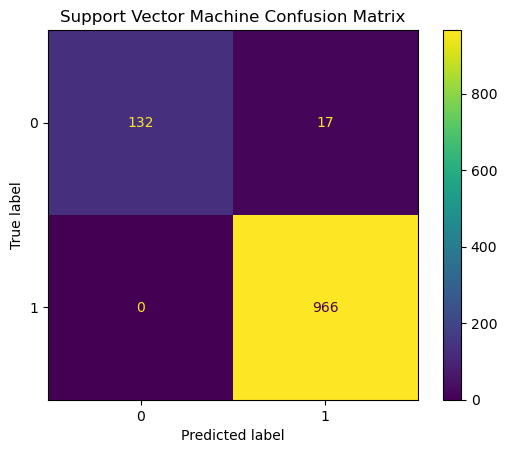

In [59]:
#Plot the confusion matrix for the nb model
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels = svm_classifier.classes_)
disp_svm.plot()
plt.title('Support Vector Machine Confusion Matrix')
plt.savefig('svm spam confusion matrix.png')
plt.show()

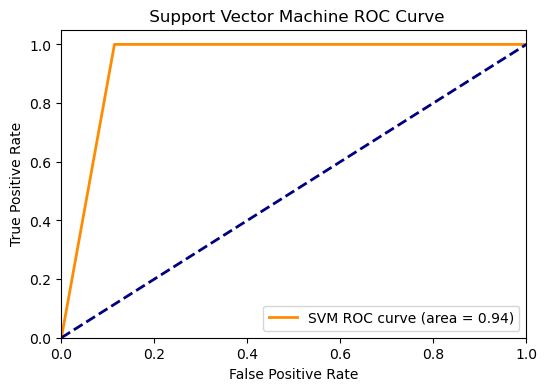

In [60]:
#Receiver Operating Characteristic Curve

y_prob_svm = svm_classifier.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='SVM ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Support Vector Machine ROC Curve')
plt.legend(loc='lower right')
plt.savefig('SVM spam ROC Curve.png')
plt.show()

## XGBoost Model

In [61]:
#Building XGBoost model
from xgboost import XGBClassifier

In [62]:
# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5)
}

# Create XGBoost classifier
xgb_classifier = XGBClassifier()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Perform hyperparameter tuning
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'colsample_bytree': 0.5909124836035503, 'gamma': 0.09170225492671691, 'learning_rate': 0.1012726728878613, 'max_depth': 8, 'n_estimators': 352, 'reg_alpha': 0.21597250932105788, 'reg_lambda': 0.14561457009902096, 'subsample': 0.8059264473611898}


In [63]:
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(colsample_bytree = 1, gamma = 0.1, learning_rate = 0.1, max_depth = 8, n_estimators = 352, reg_alpha = 0.2, reg_lambda = 0.1, subsample = 1)

In [64]:
#Train the XGBoost model
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=352,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [65]:
#predict on the test set
y_pred_xgb = xgb_classifier.predict(x_test)

In [66]:
#Display the xgb accuracy report
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print('XGBoost Accuracy:', accuracy_xgb)
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9721973094170404
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       149
           1       0.98      0.99      0.98       966

    accuracy                           0.97      1115
   macro avg       0.95      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



[[128  21]
 [ 10 956]]


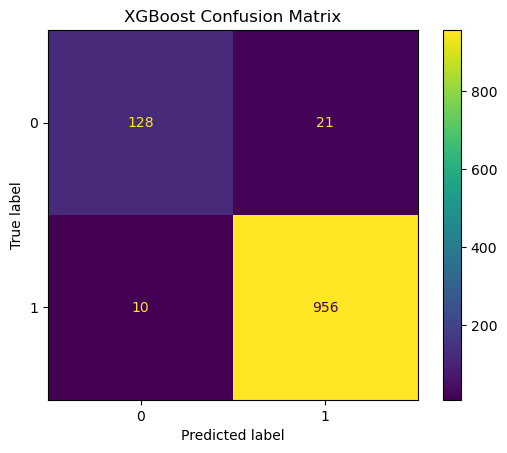

In [67]:
#Plot the confusion matrix for the nb model
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels = xgb_classifier.classes_)
disp_xgb.plot()
plt.title('XGBoost Confusion Matrix')
plt.savefig('xgb spam confusion matrix.png')
plt.show()

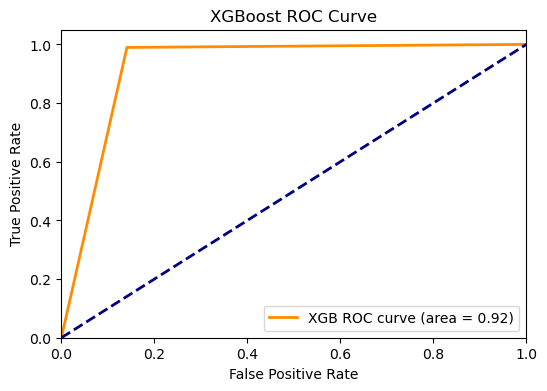

In [68]:
#Receiver Operating Characteristic Curve

y_prob_xgb = xgb_classifier.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='XGB ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.savefig('XGB spam ROC Curve.png')
plt.show()

## Model Comparison 

                    Model     Score
1  Support Vector Machine  0.984753
2                 XGBoost  0.972197
3             Naïve Bayes  0.971300
0     K-Nearest Neighbour  0.948879


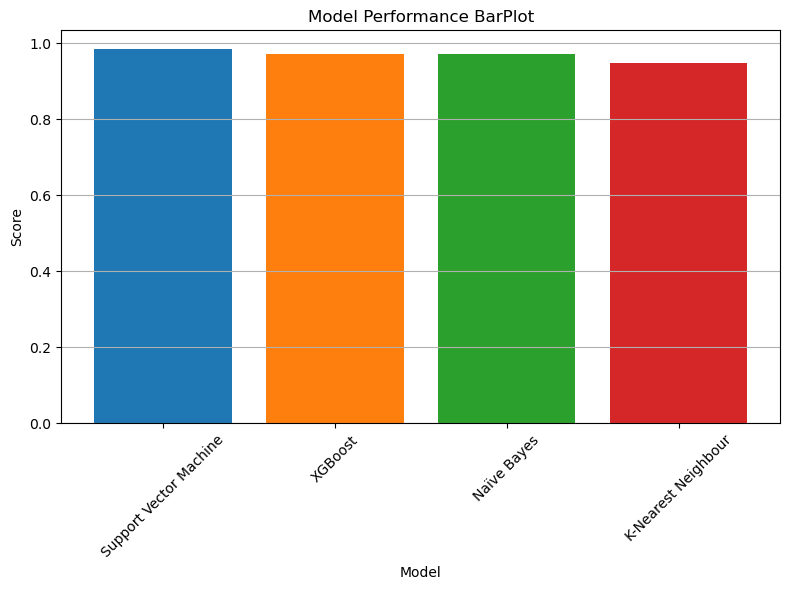

In [69]:
# Creating a DataFrame to compare the performance of different models
models = pd.DataFrame({
    'Model': ['K-Nearest Neighbour', 'Support Vector Machine', 'XGBoost', 'Naïve Bayes'],
    'Score': [accuracy_knn, accuracy_svm, accuracy_xgb, accuracy_nb]
})

# Sorting the DataFrame by the 'Score' column in descending order
models_sorted = models.sort_values(by='Score', ascending=False)
print(models_sorted)

# Plotting the performance of different models
plt.figure(figsize=(8, 6))
plt.bar(models_sorted['Model'], models_sorted['Score'], color=plt.cm.tab10(range(len(models_sorted))))
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance BarPlot')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('model_performance_barplot.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Predicting using the top two models

In [70]:
new_mail=["Congratulations on your recent achievement! Well done."]
new_data_features=feature_extraction.transform(new_mail)
prediction = svm_classifier.predict(new_data_features)
print(prediction)

if(prediction[0]==1):
    print("Ham Mail")
else:
    print("Spam Mail")

[1]
Ham Mail


In [71]:
new_mail=["To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL"]
new_data_features=feature_extraction.transform(new_mail)
prediction = xgb_classifier.predict(new_data_features)
print(prediction)

if(prediction[0]==1):
    print("Ham Mail")
else:
    print("Spam Mail")

[0]
Spam Mail
